<a href="https://colab.research.google.com/github/LucyLightCode/Mayfair_project_sentiment_analysis/blob/main/mayfair_sentiment_analysis_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT LIBRARIES & PACKAGES

In [39]:
!pip install emoji

In [40]:
!pip install langdetect

In [41]:
!pip install contractions

In [42]:
!pip install googletrans==4.0.0-rc1

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from googletrans import Translator
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

In [44]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [45]:
#nltk.download('punkt_tab', download_dir='/root/nltk_data')
nltk.download('wordnet', download_dir='/root/nltk_data')
nltk.download('omw-1.4', download_dir='/root/nltk_data')
nltk.download('stopwords', download_dir='/root/nltk_data')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## LOAD THE DATASET

In [46]:
df = pd.read_csv('/content/drive/MyDrive/Mayfair Project/combined_reviews_dataset.csv')

In [47]:
df.head(10)

,REVIEW_ID,REVIEW_CONTENT,RATING,DATE,COUNTRY
0,6.01E+16,"Same to this one as well, very classy and soft...",5.0,11/8/2024,United States
1,6.01E+16,"Beautiful colors, exactly what I wanted, but ...",4.0,10/15/2024,United States
2,6.01E+16,"This is top notch scarf, so soft and classy no...",5.0,11/8/2024,United States
3,6.01E+16,Item was great; would buy from seller again!,5.0,11/10/2024,United States
4,6.01E+16,Nice item,5.0,10/1/2024,United States
5,6.01E+16,Beautiful scarf🧣Beautiful scarf🧣Beautiful scar...,5.0,10/24/2024,United States
6,5.02E+16,The scarf color is neatly and the material is ...,5.0,11/4/2024,United States
7,6.01E+16,"Very cute super soft, the fabric is Silk",5.0,10/31/2024,United States
8,6.01E+16,👍💯💥💝🤩💚💖❤️‍🔥💙🎶😎 great toile bandana style,5.0,10/3/2024,United States
9,6.01E+16,"Just as pictured, fast shipping, very satisfied",5.0,10/12/2024,United States


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12822 entries, 0 to 12821
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REVIEW_ID       12820 non-null  object 
 1   REVIEW_CONTENT  12078 non-null  object 
 2   RATING          12457 non-null  float64
 3   DATE            12808 non-null  object 
 4   COUNTRY         12822 non-null  object 
dtypes: float64(1), object(4)
memory usage: 501.0+ KB


In [49]:
df.isnull().sum()

,0
REVIEW_ID,2
REVIEW_CONTENT,744
RATING,365
DATE,14
COUNTRY,0


In [50]:
df.duplicated().sum()

np.int64(265)

In [51]:
df.nunique()

,0
REVIEW_ID,10311
REVIEW_CONTENT,11611
RATING,5
DATE,2422
COUNTRY,110


In [52]:
df.describe(include='all')  # Includes numerical and categorical columns

,REVIEW_ID,REVIEW_CONTENT,RATING,DATE,COUNTRY
count,12820,12078,12457.000000,12808,12822
unique,10311,11611,NaN,2422,110
top,3.01E+16,Good,NaN,3/24/2025,United Kingdom
freq,1054,39,NaN,143,4381
mean,NaN,NaN,3.534960,NaN,NaN
std,NaN,NaN,1.509524,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN
25%,NaN,NaN,2.000000,NaN,NaN
50%,NaN,NaN,4.000000,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN


#  EDA

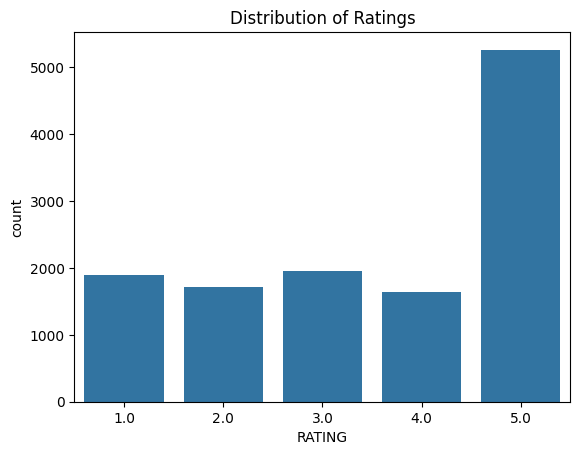

In [53]:
# Understand the frequency of each rating score
sns.countplot(x='RATING', data=df)
plt.title('Distribution of Ratings')
plt.show()

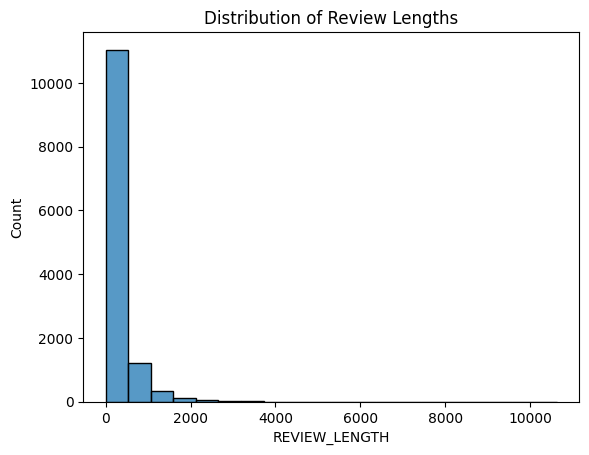

In [54]:
#Explore the length of reviews and potential relationship with ratings.
df['REVIEW_LENGTH'] = df['REVIEW_CONTENT'].astype(str).apply(len)
sns.histplot(df['REVIEW_LENGTH'], bins=20)
plt.title('Distribution of Review Lengths')
plt.show()

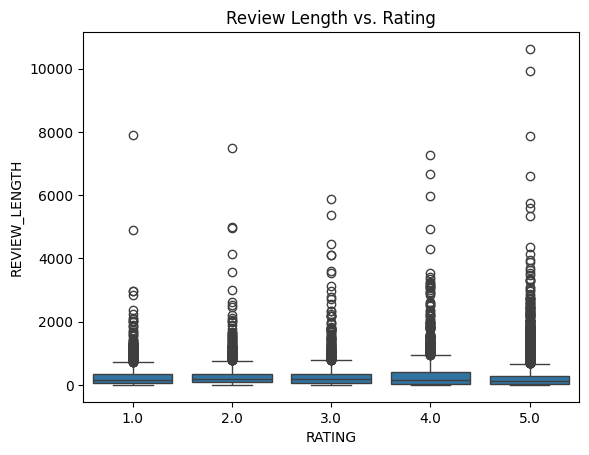

In [55]:
# Relationship between review length and rating
sns.boxplot(x='RATING', y='REVIEW_LENGTH', data=df)
plt.title('Review Length vs. Rating')
plt.show()

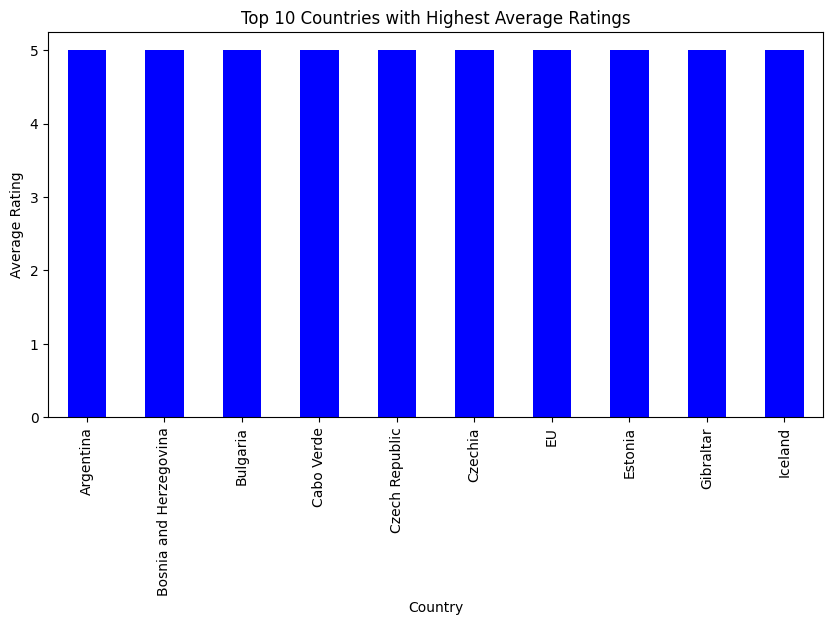

In [56]:
# Top 5 countries with highest ratings
top_10_highest = df.groupby('COUNTRY')['RATING'].mean().nlargest(10)
plt.figure(figsize=(10, 5))
top_10_highest.plot(kind='bar', color='blue')
plt.title('Top 10 Countries with Highest Average Ratings')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.show()

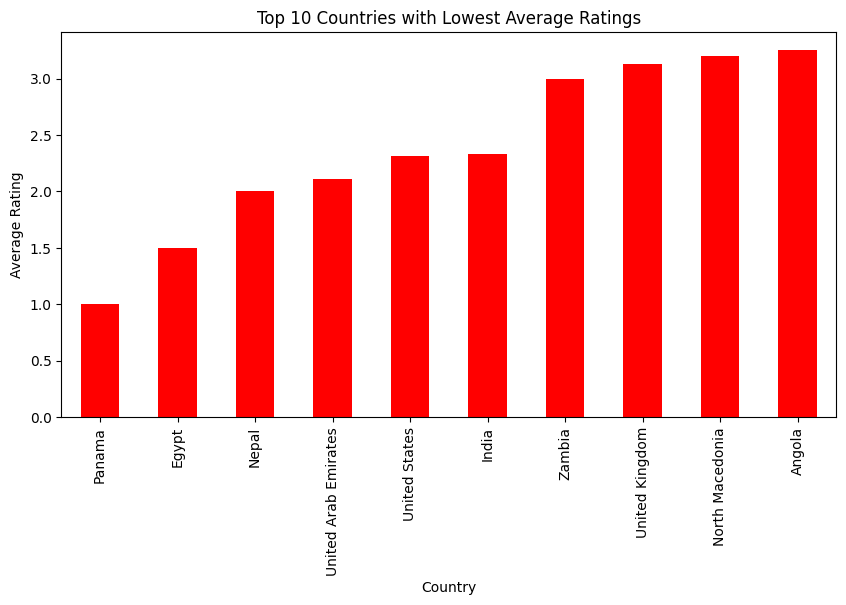

In [57]:
# Top 5 countries with lowest ratings
top_10_lowest = df.groupby('COUNTRY')['RATING'].mean().nsmallest(10)
plt.figure(figsize=(10, 5))
top_10_lowest.plot(kind='bar', color='red')
plt.title('Top 10 Countries with Lowest Average Ratings')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.show()

In [58]:
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')  # Convert to datetime, handling errors
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y', errors='coerce') #If '%m/%d/%Y' is expected
df['YEAR'] = df['DATE'].dt.year

In [59]:
#df['DATE'] = pd.to_datetime(df['DATE'])  # Convert to datetime
#df['YEAR'] = df['DATE'].dt.year

In [60]:
yearly_data = df.groupby('YEAR').agg(
    AVERAGE_RATING=('RATING', 'mean'),
    REVIEW_COUNT=('REVIEW_CONTENT', 'count')
).reset_index()

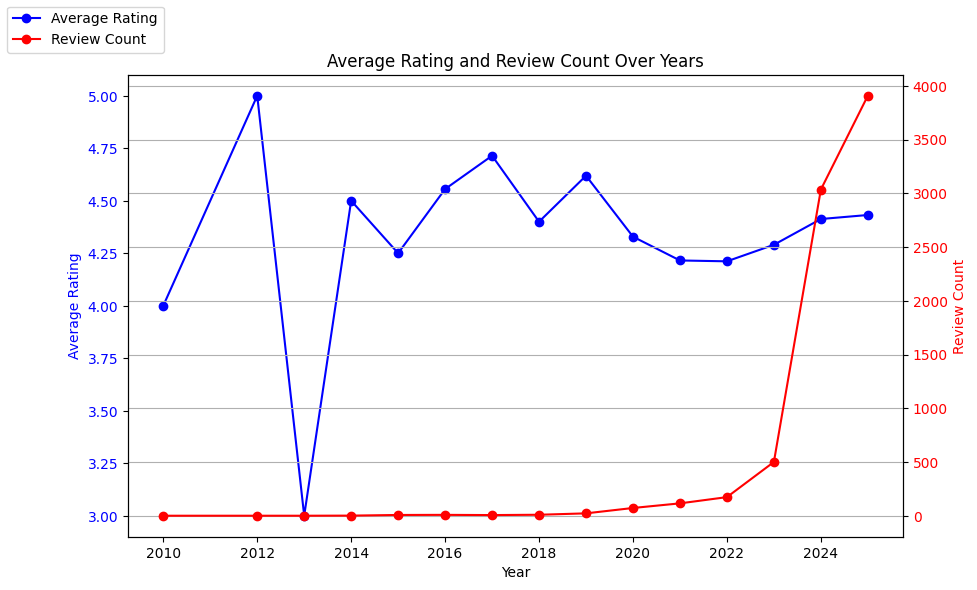

In [61]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average rating
ax1.plot(yearly_data['YEAR'], yearly_data['AVERAGE_RATING'], color='blue', label='Average Rating',marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Rating', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a second y-axis for review count
ax2 = ax1.twinx()
ax2.plot(yearly_data['YEAR'], yearly_data['REVIEW_COUNT'], color='red', label='Review Count',marker='o')
ax2.set_ylabel('Review Count', color='red')
ax2.tick_params('y', labelcolor='red')

# Add title and legend
plt.title('Average Rating and Review Count Over Years')
fig.legend(loc='upper left')
plt.grid(True)

plt.show()

## DATA CLEANING & PREPROCESSING

In [62]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from googletrans import Translator
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from nltk.stem import WordNetLemmatizer

In [63]:
# Rename columns correctly
df = df.rename(columns={'REVIEW_CONTENT': 'content', 'RATING': 'rating'})

# Subset only the relevant columns
df = df[['content', 'rating']]

# Display the first few rows
df.head(10)

,content,rating
0,"Same to this one as well, very classy and soft...",5.0
1,"Beautiful colors, exactly what I wanted, but ...",4.0
2,"This is top notch scarf, so soft and classy no...",5.0
3,Item was great; would buy from seller again!,5.0
4,Nice item,5.0
5,Beautiful scarf🧣Beautiful scarf🧣Beautiful scar...,5.0
6,The scarf color is neatly and the material is ...,5.0
7,"Very cute super soft, the fabric is Silk",5.0
8,👍💯💥💝🤩💚💖❤️‍🔥💙🎶😎 great toile bandana style,5.0
9,"Just as pictured, fast shipping, very satisfied",5.0


In [64]:
# Ensure language detection consistency
DetectorFactory.seed = 0

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
custom_stopwords = {"would", "shall", "could", "might"}
stop_words.update(custom_stopwords)
stop_words.discard("not")  # Retain "not" for sentiment analysis


In [65]:
### 1. DATA CLEANING & PREPROCESSING ###
# Function to check if a review is in English
def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")  # Remove emojis
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters & numbers
    text = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Remove duplicates & missing values
df = df.drop_duplicates(subset='content', keep='first')
df = df.dropna(subset=['content', 'rating'])
# Convert RATING to integer (if it's stored as float)
df['rating'] = df['rating'].astype(int)
df = df[df['content'].apply(is_english)]  # Keep only English reviews

df['cleaned_review'] = df['content'].apply(clean_text)

In [66]:
df.head(10)

,content,rating,cleaned_review
0,"Same to this one as well, very classy and soft...",5,one well classy soft bad smell perfect neck vi...
1,"Beautiful colors, exactly what I wanted, but ...",4,beautiful color exactly wanted item defect
2,"This is top notch scarf, so soft and classy no...",5,top notch scarf soft classy smell perfect neck...
3,Item was great; would buy from seller again!,5,item great buy seller
4,Nice item,5,nice item
6,The scarf color is neatly and the material is ...,5,scarf color neatly material also soo satisfied...
7,"Very cute super soft, the fabric is Silk",5,cute super soft fabric silk
8,👍💯💥💝🤩💚💖❤️‍🔥💙🎶😎 great toile bandana style,5,great toile bandana style
9,"Just as pictured, fast shipping, very satisfied",5,pictured fast shipping satisfied
10,Gorgeous and fast shipping!,5,gorgeous fast shipping


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11025 entries, 0 to 12821
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   content         11025 non-null  object
 1   rating          11025 non-null  int64 
 2   cleaned_review  11025 non-null  object
dtypes: int64(1), object(2)
memory usage: 344.5+ KB


In [68]:
# Create Label column based on RATING
df['labels'] = df['rating'].apply(lambda x: 2 if x >= 4 else (1 if x == 3 else 0))

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB

In [70]:
# Split into train (80%) and test (20%)
# Make sure this is imported

df = df[df['cleaned_review'].notna()] # Ensure 'cleaned_review' column has no missing values

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# Creating bag of words from cleaned_review column
vectorizer = CountVectorizer()
train_bow = vectorizer.fit_transform(train_data["cleaned_review"])
test_bow = vectorizer.transform(test_data["cleaned_review"])

In [71]:
# Creating bag of words from cleaned_review column
#vectorizer = CountVectorizer()
#train_bow = vectorizer.fit_transform(train_data["cleaned_review"])
#test_bow = vectorizer.transform(test_data["cleaned_review"])

In [72]:
# Creating tfidf matrix from cleaned_review column
vectorizer = TfidfVectorizer()
train_tfidf = vectorizer.fit_transform(train_data["cleaned_review"])
test_tfidf = vectorizer.transform(test_data["cleaned_review"])

In [75]:
# compute class weight to handle imbalance
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_data['labels']),
                                     y=train_data['labels'])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Instantiate classifiers with class weights, use class_weights as a list
classifier_bow = MultinomialNB(class_prior=class_weights.tolist()) # Changed to list
classifier_tfidf = MultinomialNB(class_prior=class_weights.tolist()) # Changed to list

# Fit the models
classifier_bow.fit(train_bow, train_data['labels'])
classifier_tfidf.fit(train_tfidf, train_data['labels'])




MultinomialNB(class_prior=[1.1475409836065573, 2.0955096222380614,
                           0.6055612770339855])

In [76]:
# Save the train and test datasets to separate files
train_data.to_csv("train_dataset.csv", index=False)
test_data.to_csv("test_dataset.csv", index=False)

In [77]:
# list of unique,classes in the label column
train_data["labels"].unique()

# In mapping ==>  old value : new value
mapped_values = {2 : "Positive",
                 1 : "Neutral" ,
                 0 : "Negative"}

In [78]:
train_data['labels'] = train_data['labels'].map(mapped_values)

In [79]:
test_data['labels'] = test_data['labels'].map(mapped_values)

In [80]:
train_data.head()

,content,rating,cleaned_review,labels
7302,"As an avid Anker consumer, I've amassed quite ...",5,avid anker consumer ive amassed quite collecti...,Positive
12442,"Good sound, shape but I expected little bit more.",3,good sound shape expected little bit,Neutral
463,"The dress is very nice, the fabric is of good ...",5,dress nice fabric good quality feel size come ...,Positive
3869,Of late I have found my Echo Dot 3rd Gen being...,5,late found echo dot rd gen moved regular basis...,Positive
4324,Product as expected an described. Very fast de...,5,product expected described fast delivery germa...,Positive


In [81]:
test_data.head()

,content,rating,cleaned_review,labels
6546,I recently switched to the GHD straightener af...,5,recently switched ghd straightener babyliss pr...,Positive
7876,"I recently purchased the Tapo Smart Bulb, Smar...",5,recently purchased tapo smart bulb smart wifi ...,Positive
9052,Bad quality. Broke after a month of buying it.,1,bad quality broke month buying,Negative
8460,I’ve always had an air fryer as I find they co...,5,ive always air fryer find cook chip better ove...,Positive
3805,Amazing product first time taking it started t...,5,amazing product first time taking started noti...,Positive


## MODELLING

In [82]:
# Vader on the normal sentences
# Vader on sentences without stop words
# Custom on train_tfidf
# Custom on train_bow

In [83]:
# Vader on the content sentences
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [84]:
analyzer = SentimentIntensityAnalyzer()

In [85]:
example_content = "I hate this product! It's bad."

In [86]:
sentiment_scores = analyzer.polarity_scores(example_content)
sentiment_scores

{'neg': 0.714, 'neu': 0.286, 'pos': 0.0, 'compound': -0.8172}

In [87]:
compound_score = sentiment_scores["compound"]

In [88]:
compound_score

-0.8172

In [89]:
def get_sentiment_label(text):
    """
    Calculates the sentiment label of a text using VADER.

    Args:
        text: The text to analyze.

    Returns:
        The sentiment label (Positive, Negative, or Neutral).
    """

    sentiment_scores = analyzer.polarity_scores(text)  # Get sentiment scores
    compound_score = sentiment_scores["compound"]  # Extract compound score

    if compound_score >= 0.05:
        return "Positive"
    elif compound_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [90]:
get_sentiment_label(example_content)

'Negative'

In [91]:
# Apply the function to the 'content' column to create a new column
test_data["vader_to_content"] = test_data["content"].apply(get_sentiment_label)

In [92]:
# Vader on the cleaned_review column
test_data["vader_to_cleaned_review"] = test_data["cleaned_review"].apply(get_sentiment_label)

In [93]:
## training custom models on bag of words and tf-idf

In [94]:
train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 222696 stored elements and shape (8820, 18049)>

In [95]:
train_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 222696 stored elements and shape (8820, 18049)>

In [96]:
## Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

In [97]:
## creating classifier objects for tfidf and bow models
classifier_bow = MultinomialNB()
classifier_tfidf = MultinomialNB()

In [98]:
# fit the models
classifier_bow.fit(train_bow, train_data["labels"])
classifier_tfidf.fit(train_tfidf, train_data["labels"])

MultinomialNB()

In [99]:
train_data['labels'].nunique()

3

In [100]:
test_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 54366 stored elements and shape (2205, 18049)>

In [101]:
test_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 54366 stored elements and shape (2205, 18049)>

In [102]:
# making predictions with classifer
#pred_bow = classifier_bow.predict(test_bow)
#pred_tfidf = classifier_tfidf.predict(test_tfidf)

In [103]:
test_data['bow'] = classifier_bow.predict(test_bow)

In [104]:
test_data['tfidf'] = classifier_tfidf.predict(test_tfidf)

In [105]:
test_data.head()

,content,rating,cleaned_review,labels,vader_to_content,vader_to_cleaned_review,bow,tfidf
6546,I recently switched to the GHD straightener af...,5,recently switched ghd straightener babyliss pr...,Positive,Positive,Positive,Positive,Positive
7876,"I recently purchased the Tapo Smart Bulb, Smar...",5,recently purchased tapo smart bulb smart wifi ...,Positive,Positive,Positive,Positive,Positive
9052,Bad quality. Broke after a month of buying it.,1,bad quality broke month buying,Negative,Negative,Negative,Negative,Negative
8460,I’ve always had an air fryer as I find they co...,5,ive always air fryer find cook chip better ove...,Positive,Positive,Positive,Positive,Positive
3805,Amazing product first time taking it started t...,5,amazing product first time taking started noti...,Positive,Positive,Positive,Positive,Positive


**MODELE EVALUATION : Using Accracy score and clasiffication report**

In [106]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [107]:
test_data.head()

,content,rating,cleaned_review,labels,vader_to_content,vader_to_cleaned_review,bow,tfidf
6546,I recently switched to the GHD straightener af...,5,recently switched ghd straightener babyliss pr...,Positive,Positive,Positive,Positive,Positive
7876,"I recently purchased the Tapo Smart Bulb, Smar...",5,recently purchased tapo smart bulb smart wifi ...,Positive,Positive,Positive,Positive,Positive
9052,Bad quality. Broke after a month of buying it.,1,bad quality broke month buying,Negative,Negative,Negative,Negative,Negative
8460,I’ve always had an air fryer as I find they co...,5,ive always air fryer find cook chip better ove...,Positive,Positive,Positive,Positive,Positive
3805,Amazing product first time taking it started t...,5,amazing product first time taking started noti...,Positive,Positive,Positive,Positive,Positive


In [108]:
vader_to_content_accuracy_score = accuracy_score(test_data["labels"], test_data["vader_to_content"])

In [109]:
vader_to_content_accuracy_score*100

65.6689342403628

In [110]:
accuracy = accuracy_score(test_data["labels"], test_data["vader_to_content"])
#printing results
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(test_data["labels"], test_data["vader_to_content"]))

Accuracy: 0.66
              precision    recall  f1-score   support

    Negative       0.63      0.50      0.55       641
     Neutral       0.21      0.10      0.13       351
    Positive       0.71      0.90      0.80      1213

    accuracy                           0.66      2205
   macro avg       0.52      0.50      0.49      2205
weighted avg       0.61      0.66      0.62      2205



<Figure size 1000x700 with 0 Axes>

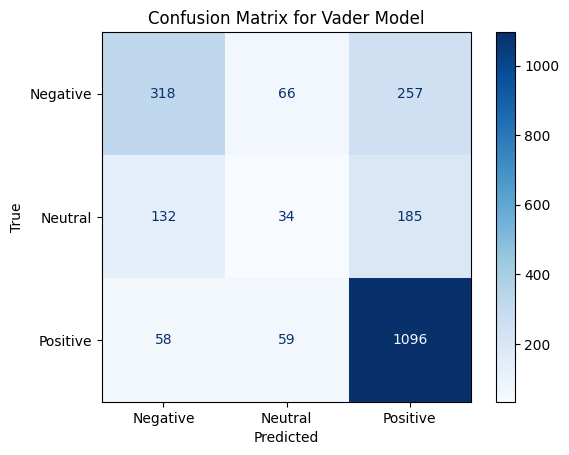

In [111]:
# confusion matrix on content
cm_vader_to_content = confusion_matrix(test_data["labels"], test_data["vader_to_content"])
plt.figure(figsize=(10, 7))
disp_vader_to_content = ConfusionMatrixDisplay(confusion_matrix=cm_vader_to_content, display_labels=classifier_bow.classes_)
disp_vader_to_content.plot(cmap="Blues")
plt.title('Confusion Matrix for Vader Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [112]:
vader_to_cleaned_review_accuracy_score = accuracy_score(test_data["labels"], test_data["vader_to_cleaned_review"])

In [113]:
vader_to_cleaned_review_accuracy_score*100

64.35374149659864

In [114]:
accuracy = accuracy_score(test_data["labels"], test_data["vader_to_cleaned_review"])
#printing results
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(test_data["labels"], test_data["vader_to_cleaned_review"]))

Accuracy: 0.64
              precision    recall  f1-score   support

    Negative       0.64      0.46      0.54       641
     Neutral       0.20      0.10      0.13       351
    Positive       0.69      0.90      0.78      1213

    accuracy                           0.64      2205
   macro avg       0.51      0.49      0.48      2205
weighted avg       0.60      0.64      0.61      2205



<Figure size 1000x700 with 0 Axes>

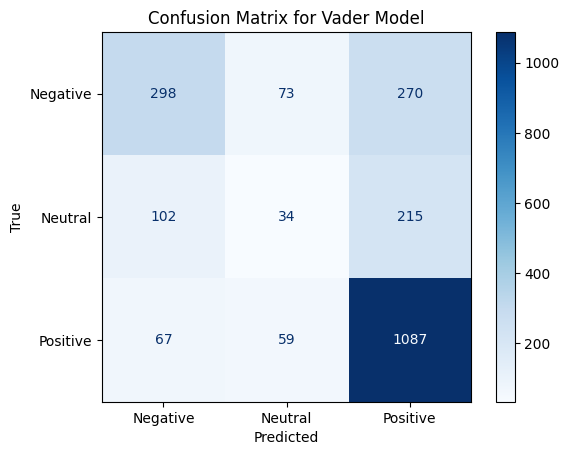

In [115]:
cm_vader_to_cleaned_review = confusion_matrix(test_data["labels"], test_data["vader_to_cleaned_review"])
plt.figure(figsize=(10, 7))
disp_vader_to_cleaned_review = ConfusionMatrixDisplay(confusion_matrix=cm_vader_to_cleaned_review, display_labels=classifier_bow.classes_)
disp_vader_to_cleaned_review.plot(cmap="Blues")
plt.title('Confusion Matrix for Vader Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [116]:
bow_accuracy_score = accuracy_score(test_data["labels"], test_data["bow"])

In [117]:
bow_accuracy_score*100

77.09750566893425

In [118]:
accuracy = accuracy_score(test_data["labels"], test_data["bow"])
#printing results
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(test_data["labels"], test_data["bow"]))

Accuracy: 0.77
              precision    recall  f1-score   support

    Negative       0.71      0.82      0.76       641
     Neutral       0.55      0.14      0.23       351
    Positive       0.82      0.93      0.87      1213

    accuracy                           0.77      2205
   macro avg       0.69      0.63      0.62      2205
weighted avg       0.74      0.77      0.74      2205



<Figure size 1000x700 with 0 Axes>

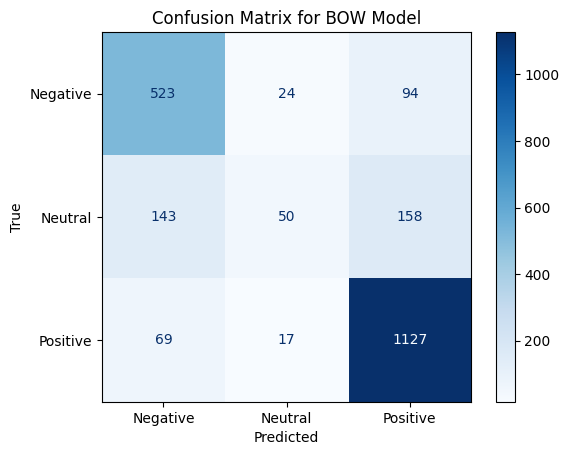

In [119]:
# confusion matrix for the 'bow' predictions:
cm_bow = confusion_matrix(test_data["labels"], test_data["bow"])
plt.figure(figsize=(10, 7))
disp_bow = ConfusionMatrixDisplay(confusion_matrix=cm_bow, display_labels=classifier_bow.classes_)
disp_bow.plot(cmap="Blues")
plt.title('Confusion Matrix for BOW Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [120]:
tfidf_accuracy_score = accuracy_score(test_data["labels"], test_data["tfidf"])

In [121]:
tfidf_accuracy_score*100

71.06575963718821

In [122]:
accuracy = accuracy_score(test_data["labels"], test_data["tfidf"])
#printing results
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(test_data["labels"], test_data["tfidf"],zero_division=0))

Accuracy: 0.71
              precision    recall  f1-score   support

    Negative       0.82      0.57      0.67       641
     Neutral       1.00      0.01      0.01       351
    Positive       0.68      0.99      0.81      1213

    accuracy                           0.71      2205
   macro avg       0.83      0.52      0.50      2205
weighted avg       0.77      0.71      0.64      2205



<Figure size 1000x700 with 0 Axes>

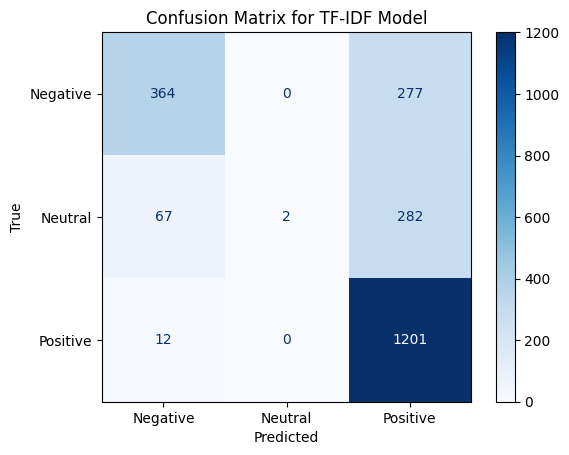

In [123]:
cm_tfidf = confusion_matrix(test_data["labels"], test_data["tfidf"])
plt.figure(figsize=(10, 7))
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=classifier_tfidf.classes_)
disp_tfidf.plot(cmap="Blues")
plt.title('Confusion Matrix for TF-IDF Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In conclution:The best perfoming model/pipeline is the cleaed_review to BOW to MultinomialNB

In [124]:
def prediction(content):
  """
  remove stopwords convert remaing content to bag of words
  pass the bag of words to classifier_bow
  return the prediction
  """
  filtered_content = clean_text(content)
  bow_content = vectorizer.transform([filtered_content])
  prediction = classifier_bow.predict(bow_content)
  return prediction

In [125]:
example_content = "I hate this product! It's bad"
prediction(example_content)

array(['Negative'], dtype='<U8')

In [126]:
example_content = "I love this product! It's amazing."
prediction(example_content)

array(['Positive'], dtype='<U8')

In [127]:
example_content = "I can say much on how I feel about this product."
prediction(example_content)

array(['Positive'], dtype='<U8')

In [128]:
example_content = " The worst product ever! It's bad looking."

In [129]:
prediction(example_content)

array(['Negative'], dtype='<U8')

DEPLOYMENT: INFERENCE SCRIPT AND FLASK APP

In [130]:
##create an inference function to recive a text, remove stopwords, convert to bow and pass to MUltinomialNB model

stop_words = set(stopwords.words("english"))
def remove_stopwords(text,stop_words = stop_words):
  words = nltk.word_tokenize(text)
  # Remove stopwords from the text
  filtered_words = [word for word in words if word.lower() not in stop_words]
  # Reconstruct the text without stopwords
  filtered_content = " ".join(filtered_words)
  #print(filtered_text)

  return filtered_content

def prediction(content):

  filtered_content = clean_text(content)
  bow_content = vectorizer.transform([filtered_content])
  prediction = classifier_bow.predict(bow_content)
  return prediction



In [131]:
example_content = "I hate this product! with passion"
prediction(example_content)

array(['Positive'], dtype='<U8')

**Model Evaluation Report**

#Interpretation

1. Bag of Words (BOW) clearly outperforms the other models in terms of accuracy, macro F1, and weighted F1, indicating that it is the most effective model at distinguishing between all three sentiment classes.

2. VADER, while simple and rule-based, struggles particularly with the neutral class, yielding low macro and weighted scores.

3. TF-IDF shows decent accuracy but completely fails to detect the neutral class (F1 = 0.01), indicating model bias towards more dominant classes.

4. The neutral class remains consistently underperforming across all models, highlighting a major challenge in the dataset or feature representation.

#Conclusion: Best Model

The Bag of Words (BOW) model is the best performer overall and is recommended for deployment or further development.

It strikes a good balance between all classes and achieves the highest scores across almost all metrics, especially in terms of positive and negative sentiment detection.

#Suggestions for Improvement
 Improve Class Balance

The neutral class is significantly underperforming — likely due to class imbalance or feature overlap.




In [132]:
###FLASK APP

!pip install Flask


In [ ]:
from flask import Flask

app = Flask(__name__)

@app.route('/')
def prediction(content):
  filtered_content = clean_text(content)
  bow_content = vectorizer.transform([filtered_content])
  prediction = classifier_bow.predict(bow_content)
  return prediction


if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)
